# Predicting Cancer Malignancy with a 2 layer neural network coded from scratch in Python.


**This notebook holds the Python code connected to this 3 part article:**

**<a href="https://towardsdatascience.com/the-keys-of-deep-learning-in-100-lines-of-code-907398c76504" target="_blank">Part 1</a> | <a href="https://towardsdatascience.com/coding-a-2-layer-neural-network-from-scratch-in-python-4dd022d19fd2" target="_blank">Part 2</a> | <a href="https://medium.com/predicting-breast-cancer-tumors-with-your-own-neural-network-76271a05e941" target="_blank">Part 3</a>**<br>

**With this code and the associated articles, you are going to:**
- Create a neural network from scratch in Python. Train it using the gradient descent algorithm.
- Apply that basic network to The Wisconsin Cancer Data-set. Predict if a tumor is benign or malignant, based on 9 different features.
- Explore deeply how back-propagation and gradient descent work.
- Review the basics and explore advanced concepts. 





In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from scipy.stats import truncnorm
from sklearn.model_selection import train_test_split
import itertools

**The Dlnet 2 layer neural network class**

A 2 layer neural network class with gradient descent in less than 100 lines of code

In [2]:
def ft_accuracy_score(y, y_pred):
    y = y.values
    y_pred = y_pred
    summa = 0.0
    m = len(y)
    for i in range(m):
        if y[i] == y_pred[i]:
            summa += 1
    return summa / m

In [3]:
class dlnet:
    def __init__(self, hidden_neurons1, hidden_neurons2, out_neurons, learning_rate=0.1):
        self.hidden_neurons1 = hidden_neurons1
        self.hidden_neurons2 = hidden_neurons2
        self.out_neurons = out_neurons

        self.param = {}
        self.cach = {}
        self.loss = []
        self.loss_valid = []
        self.lr = learning_rate

    def init_bias(self, n_neurons):
        b = np.zeros(n_neurons)
        return b.reshape(-1, 1)

    def init_weights(self, n_inputs, n_neurons):
        random_state = np.random.randint(1000)
        stddev = 2 / np.sqrt(n_inputs + n_neurons)
        weights = truncnorm.rvs(-1, 1, size=(n_neurons, n_inputs), scale=stddev, random_state=random_state)
        return weights

    def sigmoid(self, Z):
        return 1 / (1 + np.exp(-Z))

    def dsigmoid(self, Z):
        return Z * (1 - Z)
    
    def softmax(self, Z):
        return np.log(1 + np.exp(Z))
    
    def dsoftmax(self, Z):
        return np.exp(Z) / (1 + np.exp(Z))

    def init(self, m):
        self.param['W1'] = self.init_weights(m, self.hidden_neurons1)
        self.param['b1'] = self.init_bias(self.hidden_neurons1)
        self.param['W2'] = self.init_weights(self.hidden_neurons1, self.hidden_neurons2)
        self.param['b2'] = self.init_bias(self.hidden_neurons2)
        self.param['W3'] = self.init_weights(self.hidden_neurons2, self.out_neurons)
        self.param['b3'] = self.init_bias(self.out_neurons)
        pass

    def crossenthropy(self, y, y_pred):
        m = y.shape[1]
        return (-1.0 / m) * (y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred))

    def feedforward(self, X, weights, bias, activation=None):
        V = np.dot(weights, X) + bias
        if activation is not None:
            F = activation(V)
        return V, F
    
    def forward(self, X, y, activation=None):
        v1, f1 = self.feedforward(X, self.param['W1'], self.param['b1'], self.sigmoid)
        v2, f2 = self.feedforward(f1, self.param['W2'], self.param['b2'], self.sigmoid)
        v3, f3 = self.feedforward(f2, self.param['W3'], self.param['b3'], self.sigmoid)
        y_pred = f3

        self.cach['v1'] = v1
        self.cach['f1'] = f1
        self.cach['v2'] = v2
        self.cach['f2'] = f2
        self.cach['v3'] = v3
        self.cach['f3'] = f3

        loss = self.crossenthropy(y, y_pred)
        
        return y_pred, loss
    
    def backpropagation(self, X, y, y_pred):
        derror = -(np.divide(y, y_pred) - np.divide(1 - y, 1 - y_pred))

        local_grad1 = derror * self.dsigmoid(y_pred)
        grad_w3 = 1.0 / self.cach['f2'].shape[1] * np.dot(local_grad1, self.cach['f2'].T)
        grad_b3 = 1.0 / self.cach['f2'].shape[1] * np.dot(local_grad1, np.ones([local_grad1.shape[1], 1]))
        hidden_error1 = np.dot(self.param["W3"].T, local_grad1)

        local_grad2 = hidden_error1 * self.dsigmoid(self.cach['f2'])
        grad_w2 = 1. / self.cach['f1'].shape[1] * np.dot(local_grad2, self.cach['f1'].T)
        grad_b2 = 1. / self.cach['f1'].shape[1] * np.dot(local_grad2, np.ones([local_grad2.shape[1], 1]))
        hidden_error2 = np.dot(self.param['W2'].T, local_grad2)

        local_grad3 = hidden_error2 * self.dsigmoid(self.cach['f1'])
        grad_w1 = 1. / X.shape[1] * np.dot(local_grad3, X.T)
        grad_b1 = 1. / X.shape[1] * np.dot(local_grad3, np.ones([local_grad3.shape[1], 1]))

        self.param["W1"] -= self.lr * grad_w1
        self.param["b1"] -= self.lr * grad_b1
        self.param["W2"] -= self.lr * grad_w2
        self.param["b2"] -= self.lr * grad_b2
        self.param["W3"] -= self.lr * grad_w3
        self.param["b3"] -= self.lr * grad_b3
        
        pass

    def preprocess_X_y(self, X, y):
        X = X.T.values

        y = pd.DataFrame(y).copy()
        y[0] = y['target'].apply(lambda x: 0 if x == 1 else 1)
        y[1] = y['target'].apply(lambda x: 1 if x == 1 else 0)
        y.drop(['target'], axis=1, inplace=True)
        y = y.T.values

        return X, y

    def fit(self, X, y, n_epochs=3000, valid=None):
        m = X.shape[1]
        if valid != None:
            X_valid, y_valid = valid[0], valid[1]
            X_valid_for_accuracy = X_valid
            y_valid_for_accuracy = y_valid
        self.init(m)
        
        X_for_accuracy = X
        y_for_accuracy = y
        
        X, y = self.preprocess_X_y(X, y)

        i_list = []
        accuracy_list = []
        if valid != None:
            accuracy_valid_list = []
        
        for i in range(1, n_epochs + 1):
            if valid != None:
                y_proba_valid, loss_valid = self.predict_proba(X_valid, y_valid)
            
            y_proba, loss = self.forward(X, y)
            self.backpropagation(X, y, y_proba)
            
            ##-- loss
            if valid != None:
                loss_valid = np.sum(np.sum(loss_valid, axis=1))
            loss = np.sum(np.sum(loss, axis=1))
            
            ##-- predictions
            if valid != None:
                y_pred_valid = self.predict(X_valid_for_accuracy, y_valid_for_accuracy)
            y_pred = self.predict(X_for_accuracy, y_for_accuracy)
            
            ##-- accuracy
            if valid != None:
                accuracy_valid = ft_accuracy_score(y_valid_for_accuracy, y_pred_valid)
            accuracy = ft_accuracy_score(y_for_accuracy, y_pred)
            
            ##-- print
            if valid == None:
                print("epoch {0:>5}/{1} - loss: {2:<6.4} - accuracy: {3:<6.4}".format(i, n_epochs, loss, accuracy))
            else:
                print("epoch {0:>5}/{1} - loss: {2:<6.4} - accuracy: {3:<6.4} - val_loss: {4:<6.4} - val_accuracy: {5:.4}".format(i, n_epochs, loss, 
                                                                                   accuracy, loss_valid, 
                                                                                   accuracy_valid))
            
            ##-- append
            if valid != None:
                self.loss_valid.append(loss_valid)
                accuracy_valid_list.append(accuracy_valid)
            self.loss.append(loss)
            i_list.append(i)
            accuracy_list.append(accuracy)
        
        plt.figure(figsize=(16, 6))
        plt.plot(i_list, self.loss, label='loss')
        if valid != None:
            plt.plot(i_list, self.loss_valid, label='val_loss')     
            plt.plot(i_list, accuracy_valid_list, label='val_accuracy') 
        plt.plot(i_list, accuracy_list, label='accuracy')
        
        plt.title("Learning rate =" + str(self.lr))
        plt.legend()
        plt.grid(True)
        plt.show()

        return


    def predict_proba(self, X, y):
        X, y = self.preprocess_X_y(X, y)
        y_pred, loss = self.forward(X, y)
        return y_pred, loss

    def predict(self, X, y):
        y_pred, _ = self.predict_proba(X, y)
        predict = np.array([x for x in y_pred.argmax(axis=0)])
        return predict

# Prepare the data

In [4]:
df = pd.read_csv('data.csv', names = ['1','target','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','21','22','23','24','25','26','27','28','29','30','31','32'] )
df.drop(['1'], axis=1, inplace=True)
df['target'] = df['target'].apply(lambda x: 1 if x=='M' else 0)
not_normalized_cols = ['3', '4', '5', '6', '15', '16', '23', '24', '25', '26']
scaler = MinMaxScaler()
df[not_normalized_cols] = scaler.fit_transform(df[not_normalized_cols])
target = df['target'].copy()
df.drop(['target'], axis=1, inplace=True)

In [5]:
X = df
y = target

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [7]:
X_valid, y_valid = X_train[:50], y_train[:50]
X_train, y_train = X_train[50:], y_train[50:]

epoch     1/100 - loss: 1.329  - accuracy: 0.6444 - val_loss: 1.432  - val_accuracy: 0.52
epoch     2/100 - loss: 1.324  - accuracy: 0.6444 - val_loss: 1.431  - val_accuracy: 0.52
epoch     3/100 - loss: 1.32   - accuracy: 0.6444 - val_loss: 1.431  - val_accuracy: 0.52
epoch     4/100 - loss: 1.316  - accuracy: 0.6444 - val_loss: 1.431  - val_accuracy: 0.52
epoch     5/100 - loss: 1.314  - accuracy: 0.6444 - val_loss: 1.431  - val_accuracy: 0.52
epoch     6/100 - loss: 1.311  - accuracy: 0.6444 - val_loss: 1.432  - val_accuracy: 0.52
epoch     7/100 - loss: 1.31   - accuracy: 0.6444 - val_loss: 1.433  - val_accuracy: 0.52
epoch     8/100 - loss: 1.308  - accuracy: 0.6444 - val_loss: 1.433  - val_accuracy: 0.52
epoch     9/100 - loss: 1.307  - accuracy: 0.6444 - val_loss: 1.434  - val_accuracy: 0.52
epoch    10/100 - loss: 1.306  - accuracy: 0.6444 - val_loss: 1.435  - val_accuracy: 0.52
epoch    11/100 - loss: 1.305  - accuracy: 0.6444 - val_loss: 1.436  - val_accuracy: 0.52
epoch    1

epoch    99/100 - loss: 1.298  - accuracy: 0.6444 - val_loss: 1.445  - val_accuracy: 0.52
epoch   100/100 - loss: 1.298  - accuracy: 0.6444 - val_loss: 1.445  - val_accuracy: 0.52


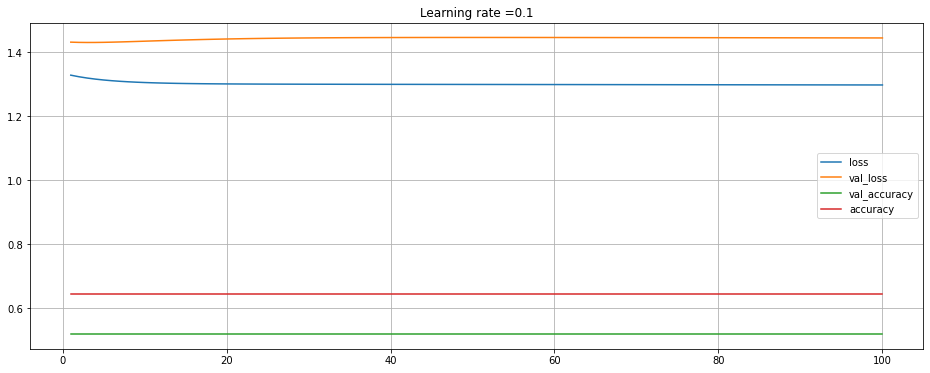

In [8]:
# %%time
nn = dlnet(20, 10, 2, 0.1)
nn.fit(X_train, y_train, n_epochs=100, valid=(X_valid, y_valid))

In [9]:
y_proba, _ = nn.predict_proba(X_test, y_test)
pd.DataFrame(y_proba)

,0,1,2,3,4,5,6,7,8,9,...,104,105,106,107,108,109,110,111,112,113
0,0.644266,0.646439,0.646092,0.644557,0.646180,0.643376,0.644385,0.644765,0.646846,0.645209,...,0.643908,0.642578,0.645884,0.646889,0.646344,0.645255,0.644235,0.648201,0.645441,0.644887
1,0.354714,0.354312,0.354162,0.354975,0.354104,0.354680,0.354614,0.355660,0.353251,0.354330,...,0.354583,0.357101,0.354257,0.353694,0.353890,0.354390,0.355308,0.353114,0.354877,0.354268


In [10]:
y_pred = nn.predict(X_test, y_test)
pd.DataFrame(y_pred)

,0
0,0
1,0
2,0
3,0
4,0
...,...
109,0
110,0
111,0
112,0


In [11]:
print("{}: {}".format("Accuracy", ft_accuracy_score(y_test, y_pred)))

Accuracy: 0.6140350877192983


In [12]:
pd.DataFrame(y_test).T

,494,465,436,421,403,275,246,11,341,397,...,142,95,74,52,404,480,100,166,91,96
target,0,0,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,1,0,1,0


In [13]:
pd.DataFrame(y_pred).T

,0,1,2,3,4,5,6,7,8,9,...,104,105,106,107,108,109,110,111,112,113
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
confusion_matrix(y_test, y_pred)

array([[70,  0],
       [44,  0]], dtype=int64)

In [15]:
def plotCf(a,b,t):
    cf =confusion_matrix(a,b)
    plt.imshow(cf,cmap=plt.cm.Blues,interpolation='nearest')
    plt.colorbar()
    plt.title(t)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    tick_marks = np.arange(len(set(a))) # length of classes
    class_labels = ['0','1']
    plt.xticks(tick_marks,class_labels)
    plt.yticks(tick_marks,class_labels)
    thresh = cf.max() / 2.
    for i,j in itertools.product(range(cf.shape[0]),range(cf.shape[1])):
        plt.text(j,i,format(cf[i,j],'d'),horizontalalignment='center',color='white' if cf[i,j] >thresh else 'black')
    plt.show();

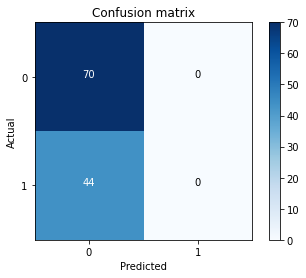

In [16]:
plotCf(y_test, y_pred, 'Confusion matrix')